In [78]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Optimizer

import sklearn


import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

random_seed = 42

In [79]:
from sklearn import datasets as skdatasets

moons = skdatasets.make_moons(n_samples=300, noise=1e-1, random_state=random_seed)
# put moon dataset into pytorch dataloader
X = moons[0]
y = moons[1]
# put y in one-hot encoding
y = np.eye(2)[y]

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


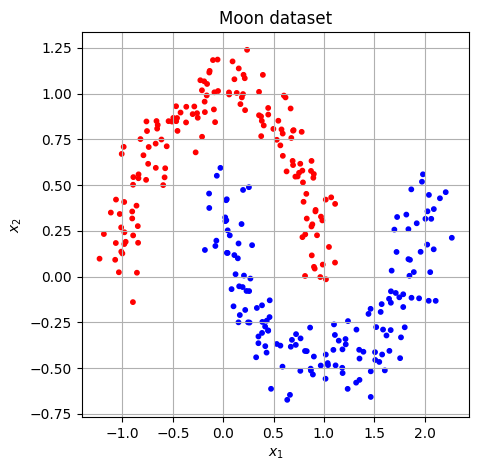

In [80]:
# plot moon dataset
plt.figure(figsize=(5, 5))
plt.title("Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.grid()
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], s=10, cmap="bwr")
plt.show()


In [123]:
# Custom Binarized Linear Layer
class BinarizedLinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias_bool=True, input_layer=False):
        # Initialize the parent class
        super(BinarizedLinearLayer, self).__init__()

        # Store the input layer and bias status
        self.input_layer = input_layer
        self.bias_bool = bias_bool

        # Initialize weight and bias parameters
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if self.bias_bool:
            self.bias = nn.Parameter(torch.Tensor(out_features))

        # Reset parameters with uniform distribution
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weight and bias with uniform distribution
        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias_bool:
            nn.init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, input):
        # Binarize the input and weights using the sign function
        binarized_input = torch.sign(input)
        if self.input_layer:
            binarized_input = input
        binarized_weight = torch.sign(self.weight)

        # Compute the linear function with binarized input and weights
        if self.bias_bool:
            return nn.functional.linear(binarized_input, binarized_weight, self.bias)
        else:
            return nn.functional.linear(binarized_input, binarized_weight)


class SignActivation(
    torch.autograd.Function
):  # We define a sign activation with derivative equal to clip
    @staticmethod
    def forward(ctx, i):
        result = i.sign()
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        (i,) = ctx.saved_tensors
        grad_i = grad_output.clone()
        grad_i[i.abs() > 1.0] = 0
        return grad_i


# Custom Binarized Neural Network
class BNN(nn.Module):
    def __init__(self, architecture=(2, 10, 10, 2)):
        # Initialize the parent class
        super(BNN, self).__init__()

        # Store the network architecture
        self.architecture = architecture

        # Create binarized linear layers according to the architecture
        for i in range(len(architecture) - 1):
            if i == 0:
                # Set the input layer attribute
                setattr(
                    self,
                    "fc" + str(i),
                    BinarizedLinearLayer(
                        architecture[i],
                        architecture[i + 1],
                        bias_bool=False,
                        input_layer=True,
                    ),
                )
                # set the batchnorm
                setattr(
                    self,
                    "bn" + str(i),
                    torch.nn.BatchNorm1d(
                        architecture[i + 1], affine=False, track_running_stats=True
                    ),
                )
            else:
                # Set the hidden layer attributes
                setattr(
                    self,
                    "fc" + str(i),
                    BinarizedLinearLayer(
                        architecture[i], architecture[i + 1], bias_bool=False
                    ),
                )
                # set the batchnorm
                setattr(
                    self,
                    "bn" + str(i),
                    torch.nn.BatchNorm1d(
                        architecture[i + 1], affine=False, track_running_stats=True
                    ),
                )

    def forward(self, x):
        # Propagate the input through the network layers
        for i in range(len(self.architecture) - 2):
            x = getattr(self, "fc" + str(i))(x)
            x = getattr(self, "bn" + str(i))(x)
            # apply relu
            x = torch.relu(x)  # SignActivation.apply(x) # torch.relu(x)
        x = getattr(self, "fc" + str(len(self.architecture) - 2))(x)
        x = getattr(self, "bn" + str(len(self.architecture) - 2))(x)
        # set softmax as output layer
        x = torch.softmax(x, dim=1)
        return x


# Metaplastic Gradient Descent
class MetaplasticGD(Optimizer):
    def __init__(self, params, lr=0.01, weight_decay=0, meta=0.75):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(MetaplasticGD, self).__init__(params, defaults)
        self.meta = meta

    def metaplastic_function(self, x):
        return 1 - torch.tanh(self.meta * x).pow(2)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                # Calculate gradient descent
                d_p = p.grad.data

                # Apply weight decay
                if group["weight_decay"] != 0:
                    d_p.add_(p.data, alpha=group["weight_decay"])

                # calculate if the update decreases the absolute value of a weight
                weight_diff = (-torch.sign(group["lr"] * d_p) * torch.sign(p.data)) > 0

                # calculate the metaplastic learning rate
                metaplastic_learning_rate = (
                    self.metaplastic_function(p.data) * weight_diff + ~weight_diff
                )

                # Update hidden weights with custom condition
                p.data.add_(-metaplastic_learning_rate * group["lr"] * d_p)

        return loss


# Metaplastic Adam
class Adam_meta(torch.optim.Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        meta=0.75,
        eps=1e-8,
        weight_decay=0,
        amsgrad=False,
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(
            lr=lr,
            betas=betas,
            meta=meta,
            eps=eps,
            weight_decay=weight_decay,
            amsgrad=amsgrad,
        )
        super(Adam_meta, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam_meta, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("amsgrad", False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        "Adam does not support sparse gradients, please consider SparseAdam instead"
                    )
                amsgrad = group["amsgrad"]

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                    if len(p.size()) != 1:
                        state["followed_weight"] = np.random.randint(
                            p.size(0)
                        ), np.random.randint(p.size(1))
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state["max_exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                if amsgrad:
                    max_exp_avg_sq = state["max_exp_avg_sq"]
                beta1, beta2 = group["betas"]

                state["step"] += 1

                if group["weight_decay"] != 0:
                    grad.add_(group["weight_decay"], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group["eps"])
                else:
                    denom = exp_avg_sq.sqrt().add_(group["eps"])

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]
                step_size = group["lr"] * math.sqrt(bias_correction2) / bias_correction1

                binary_weight_before_update = torch.sign(p.data)
                condition_consolidation = (
                    torch.mul(binary_weight_before_update, exp_avg) > 0.0
                )

                decay = torch.max(0.3 * torch.abs(p.data), torch.ones_like(p.data))
                decayed_exp_avg = torch.mul(
                    torch.ones_like(p.data)
                    - torch.pow(torch.tanh(group["meta"] * torch.abs(p.data)), 2),
                    exp_avg,
                )
                exp_avg_2 = torch.div(exp_avg, decay)

                if len(p.size()) == 1:  # True if p is bias, false if p is weight
                    p.data.addcdiv_(-step_size, exp_avg, denom)
                else:
                    # p.data.addcdiv_(-step_size, exp_avg , denom)  #normal update
                    p.data.addcdiv_(
                        -step_size,
                        torch.where(condition_consolidation, decayed_exp_avg, exp_avg),
                        denom,
                    )  # assymetric lr for metaplasticity

        return loss

Epoch: 0, loss: 1.167
Epoch: 10, loss: 9.583
Epoch: 20, loss: 2.333
Epoch: 30, loss: 8.166
Epoch: 40, loss: 8.166
Epoch: 50, loss: 6.999
Epoch: 60, loss: 5.833
Epoch: 70, loss: 4.666
Epoch: 80, loss: 6.999
Epoch: 90, loss: 5.833


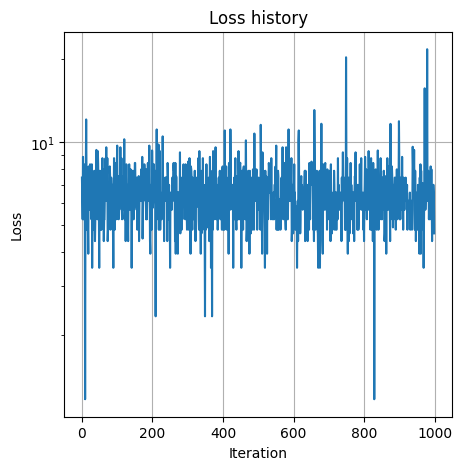

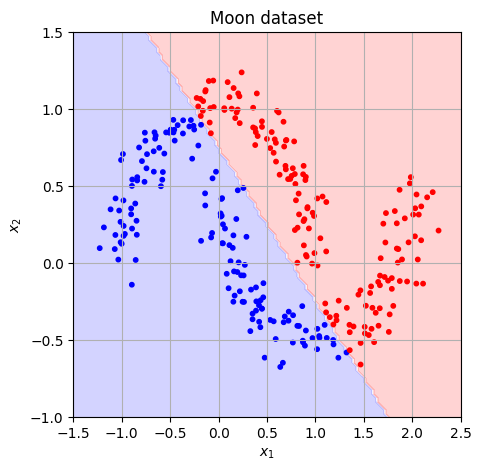

In [111]:
# Create an instance of the custom binarized fully connected network
net = BNN(architecture=(2, 50, 2))

# Define the binary cross entropy loss
criterion = nn.BCELoss()

# Create an instance of the custom optimizer
# optimizer = MetaplasticGD(
#     net.parameters(), lr=0.05, weight_decay=0.001, metaplastic_parameter=0
# )

optimizer = Adam_meta(
    net.parameters(), lr=2e-3, betas=(0.9, 0.999), meta=0.75, eps=1e-7, weight_decay=0
)

# learn the moon dataset for 100 epoch and save the loss
loss_history = []
for epoch in range(100):
    for i, (X_i, y_i) in enumerate(dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_i)
        loss = criterion(y_pred, y_i)
        loss.backward()
        optimizer.step()

        # save loss
        loss_history.append(loss.item())

    # print the loss every 10 epochs
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %.3f" % (epoch, loss.item()))

# plot the loss
plt.figure(figsize=(5, 5))
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.yscale("log")
plt.plot(loss_history)
plt.show()


# pass X into the model
y_pred = net(X)
# plot the result
plt.figure(figsize=(5, 5))
plt.title("Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.grid()


# plot the decision boundary
x1 = np.linspace(-1.5, 2.5, 100)
x2 = np.linspace(-1, 1.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
X_grid = np.concatenate((xx1.reshape(-1, 1), xx2.reshape(-1, 1)), axis=1)
y_grid = net(torch.Tensor(X_grid)).detach().numpy()
plt.contourf(xx1, xx2, y_grid[:, 0].reshape(xx1.shape), cmap="bwr", alpha=0.2)
plt.scatter(
    X[:, 0], X[:, 1], c=(y_pred[:, 0] >= 0.5).detach().numpy(), s=10, cmap="bwr"
)

plt.show()

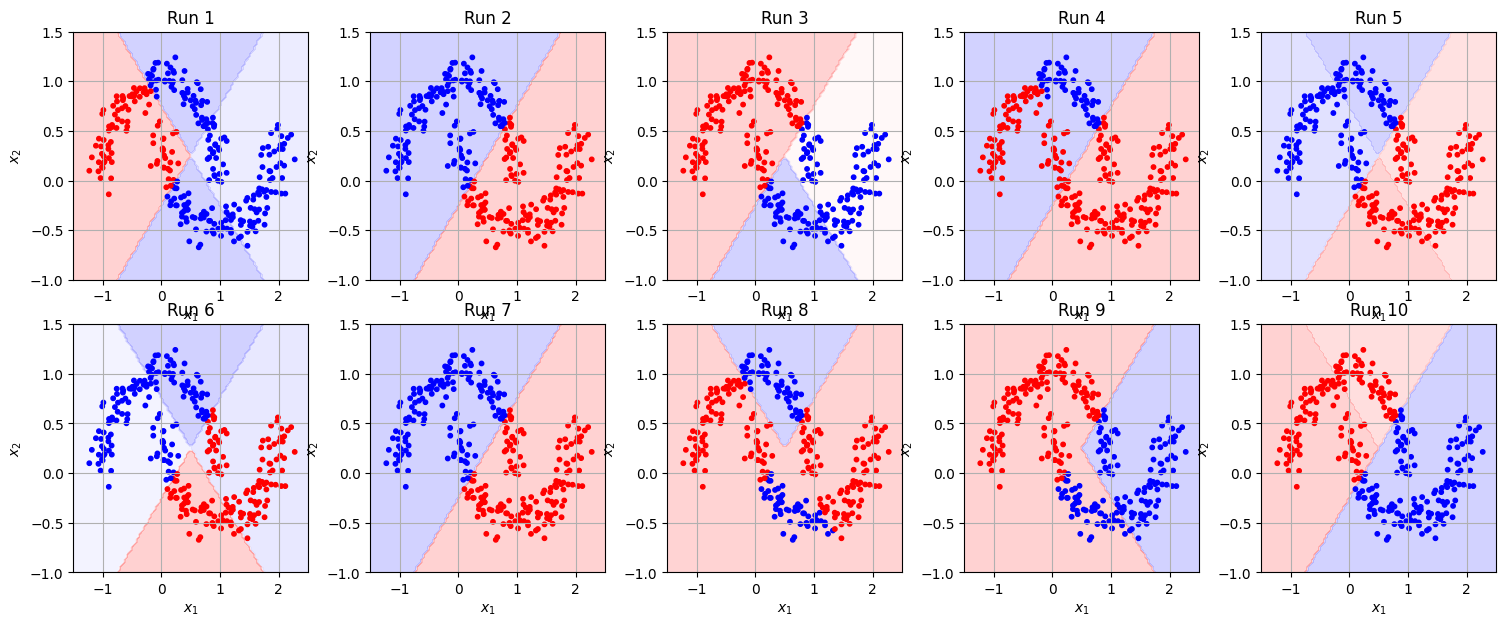

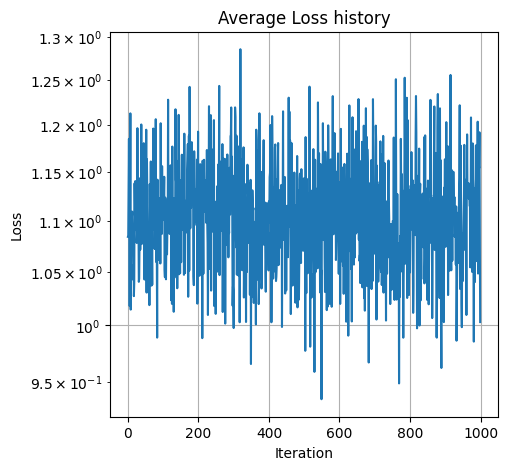

In [138]:
import numpy as np
import matplotlib.pyplot as plt


def train_and_plot(net, dataloader, num_epochs=100):
    # Define the binary cross entropy loss
    criterion = nn.BCELoss()

    # Create an instance of the custom optimizer
    optimizer = Adam_meta(
        net.parameters(),
        lr=1e-2,
        betas=(0.9, 0.999),
        meta=0,
        eps=1e-7,
        weight_decay=0.00001,
    )

    # Learn the moon dataset for num_epochs and save the loss
    loss_history = []
    for epoch in range(num_epochs):
        for i, (X_i, y_i) in enumerate(dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            y_pred = net(X_i)
            loss = criterion(y_pred, y_i)
            loss.backward()
            optimizer.step()

            # Save loss
            loss_history.append(loss.item())

    return loss_history


num_runs = 10
all_loss_histories = []

# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.tight_layout()

for run in range(num_runs):
    # Create an instance of the custom binarized fully connected network
    net = BNN(architecture=(2, 20, 20, 20, 2))

    # Train the network for 100 epochs and save the loss
    loss_history = []
    for epoch in range(100):
        for i, (X_i, y_i) in enumerate(dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            y_pred = net(X_i)
            loss = criterion(y_pred, y_i)
            loss.backward()
            optimizer.step()

            # Save loss
            loss_history.append(loss.item())

    all_loss_histories.append(loss_history)

    # Pass X into the model
    y_pred = net(X)

    # Plot the decision boundary
    x1 = np.linspace(-1.5, 2.5, 100)
    x2 = np.linspace(-1, 1.5, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    X_grid = np.concatenate((xx1.reshape(-1, 1), xx2.reshape(-1, 1)), axis=1)
    y_grid = net(torch.Tensor(X_grid)).detach().numpy()

    # Plot the representation in a subplot
    ax = axes[run // 5, run % 5]
    ax.contourf(xx1, xx2, y_grid[:, 0].reshape(xx1.shape), cmap="bwr", alpha=0.2)
    ax.scatter(
        X[:, 0], X[:, 1], c=(y_pred[:, 0] >= 0.5).detach().numpy(), s=10, cmap="bwr"
    )
    ax.set_title(f"Run {run + 1}")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.grid()

plt.show()

# Calculate the average loss history
average_loss_history = np.mean(all_loss_histories, axis=0)

# Plot the average loss history
plt.figure(figsize=(5, 5))
plt.title("Average Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.yscale("log")
plt.plot(average_loss_history)
plt.show()

In [83]:
# initialisation ? Learning algo ? regarder la tête des poids


Epoch: 0, loss: 0.912
Epoch: 10, loss: 0.992
Epoch: 20, loss: 0.792
Epoch: 30, loss: 0.975
Epoch: 40, loss: 0.673
Epoch: 50, loss: 0.840
Epoch: 60, loss: 0.909
Epoch: 70, loss: 0.939
Epoch: 80, loss: 1.040
Epoch: 90, loss: 0.828


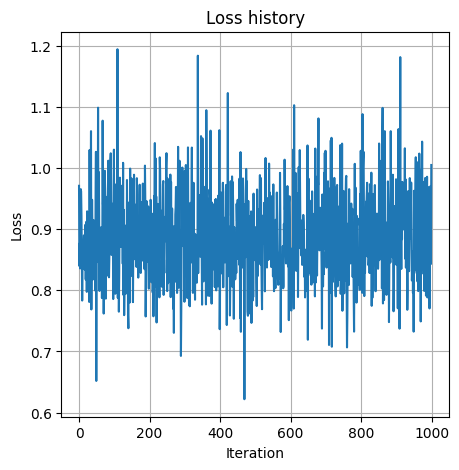

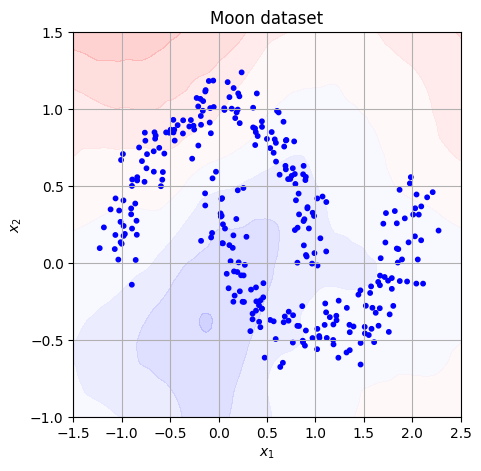

In [136]:
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


# Create an instance of the network
net_2 = SimpleNet()


# Define the binary cross entropy loss
criterion = nn.BCELoss()

# Create an instance of the custom optimizer
# optimizer = MetaplasticGD(
#     net.parameters(), lr=0.05, weight_decay=0.001, metaplastic_parameter=0
# )

optimizer = torch.optim.Adam(
    net_2.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-7, weight_decay=0
)

# learn the moon dataset for 100 epoch and save the loss
loss_history_2 = []
for epoch in range(100):
    for i, (X_i, y_i) in enumerate(dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_i)
        loss = criterion(y_pred, y_i)
        loss.backward()
        optimizer.step()

        # save loss
        loss_history_2.append(loss.item())

    # print the loss every 10 epochs
    if epoch % 10 == 0:
        print("Epoch: %d, loss: %.3f" % (epoch, loss.item()))

# plot the loss
plt.figure(figsize=(5, 5))
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.plot(loss_history)
plt.show()


# pass X into the model
y_pred = net_2(X)
# plot the result
plt.figure(figsize=(5, 5))
plt.title("Moon dataset")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.grid()


# plot the decision boundary
x1 = np.linspace(-1.5, 2.5, 100)
x2 = np.linspace(-1, 1.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
X_grid = np.concatenate((xx1.reshape(-1, 1), xx2.reshape(-1, 1)), axis=1)
y_grid = net_2(torch.Tensor(X_grid)).detach().numpy()
plt.contourf(xx1, xx2, y_grid[:, 0].reshape(xx1.shape), cmap="bwr", alpha=0.2)
plt.scatter(
    X[:, 0], X[:, 1], c=(y_pred[:, 0] >= 0.5).detach().numpy(), s=10, cmap="bwr"
)

plt.show()

In [131]:
y_pred


tensor([[0.4702, 0.5298],
        [0.4617, 0.5383],
        [0.4821, 0.5179],
        [0.4857, 0.5143],
        [0.4601, 0.5399],
        [0.4642, 0.5358],
        [0.4754, 0.5246],
        [0.4848, 0.5152],
        [0.4789, 0.5211],
        [0.4798, 0.5202],
        [0.4659, 0.5341],
        [0.4905, 0.5095],
        [0.4626, 0.5374],
        [0.4928, 0.5072],
        [0.4791, 0.5209],
        [0.4600, 0.5400],
        [0.4738, 0.5262],
        [0.4690, 0.5310],
        [0.4788, 0.5212],
        [0.4808, 0.5192],
        [0.4937, 0.5063],
        [0.4827, 0.5173],
        [0.4581, 0.5419],
        [0.4596, 0.5404],
        [0.4844, 0.5156],
        [0.4918, 0.5082],
        [0.4711, 0.5289],
        [0.4738, 0.5262],
        [0.4800, 0.5200],
        [0.4643, 0.5357],
        [0.4884, 0.5116],
        [0.4800, 0.5200],
        [0.4919, 0.5081],
        [0.4868, 0.5132],
        [0.4708, 0.5292],
        [0.4828, 0.5172],
        [0.4762, 0.5238],
        [0.4927, 0.5073],
        [0.4

In [139]:
from keras.datasets import fashion_mnist, mnist


ModuleNotFoundError: No module named 'keras'